# Определение возраста покупателей

<p style='text-align: justify;'>
    Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:</p>
    
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
<p style='text-align: justify;'>Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Имеется набор фотографий людей с указанием возраста: одна папка со всеми изображениями <i>(/final_files)</i> и CSV-файл <i>labels.csv</i> с двумя колонками: <i>file_name</i> и <i>real_age</i>.</p>

<hr>

<div align='left'><b>План работы:</b></div>

1. [Исследовательский анализ данных](#section1):
2. [Обучение модели](#section2)
3. [Анализ обученной модели](#section3)

<hr>

In [1]:
import re
import random as rd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<a id='section1'></a>

## Исследовательский анализ данных

<hr>

Загрузим данные, выведем первые строки и посмотрим основную информацию о данных.

<hr>

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
display(data.head())
data.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<hr>

<p style='text-align: justify;'>Получен фрейм, содержащий названия файлов с фотографиями (<i>file_name</i>) и возрост людей (<i>real_age</i>), которые изображены на фотографиях. Пропусков в данных нет. В фрейме содержится 7591 строка и 2 столбца.<br><br>
Создадим генераторы для генерации размеченных тестовых батчей.</p>

<hr>

In [4]:
train_datagen = ImageDataGenerator(validation_split=0.2, 
                                   rescale=1./255)

valid_datagen = ImageDataGenerator(validation_split=0.2, 
                                   rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_dataframe(dataframe=data, 
                                                    directory='/datasets/faces/final_files', 
                                                    x_col='file_name', 
                                                    y_col='real_age', 
                                                    target_size=(150, 150),
                                                    class_mode='raw', 
                                                    batch_size=32, 
                                                    subset='training', 
                                                    seed=1)
validation_generator = valid_datagen.flow_from_dataframe(dataframe=data, 
                                                         directory='/datasets/faces/final_files', 
                                                         x_col='file_name', 
                                                         y_col='real_age', 
                                                         target_size=(150, 150), 
                                                         class_mode='raw', 
                                                         batch_size=32, 
                                                         subset='validation', 
                                                         seed=1)

Found 6073 validated image filenames.
Found 1518 validated image filenames.


<hr>

Для тестового генераторы было взято 6073 изображения, что соответствует примерно 80% от исходного объема данных. Посмотрим пример изображений из одного батча.

<hr>

In [6]:
features, target = next(train_generator)

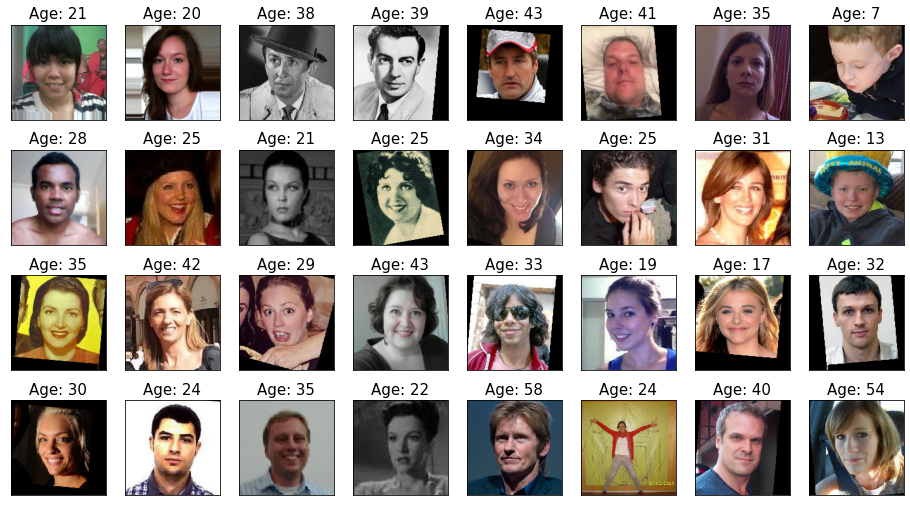

In [7]:
fig = plt.figure(figsize=(16,9))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(f'Age: {target[i]}', fontsize=15)
plt.subplots_adjust(hspace=0.1)

<hr>

<p style='text-align: justify;'>Многие фотографии в исходном виде встречаются в черно-белом исполнении, камеры в магазине будут снимать в одном цветовом режиме, поэтому обучающие данные тоже должны быть в этом режиме.<br><br>
Посмотрим на распределение и числовое описание целевого признака в данных - возраста людей, изображенных на фотографиях.</p>

<hr>

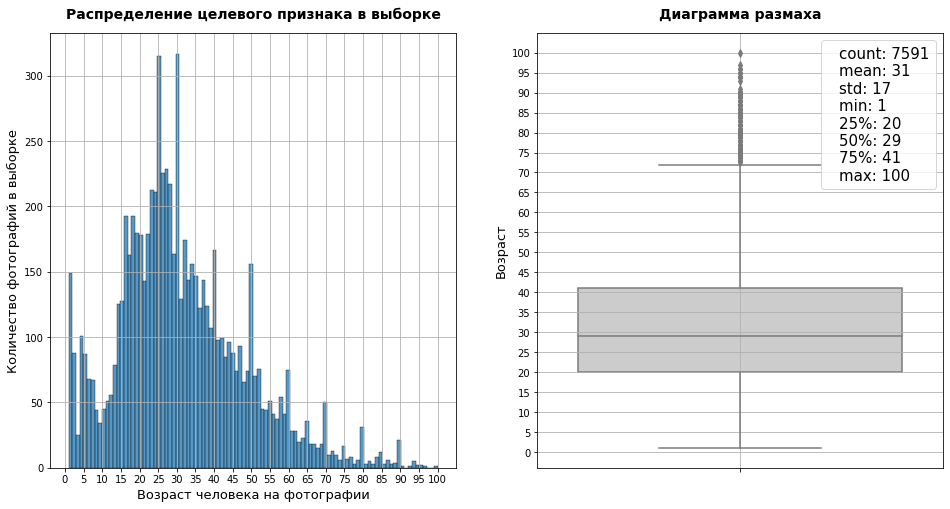

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

sns.histplot(data, x='real_age', bins=100, ax=axes[0])
axes[0].set_title('Распределение целевого признака в выборке', weight='bold', size=14, pad=15)
axes[0].set_xlabel('Возраст человека на фотографии', size=13)
axes[0].set_ylabel('Количество фотографий в выборке', size=13)
axes[0].set_xticks(range(0, 105, 5))
axes[0].grid()

stats = data['real_age'].describe().astype('int')
legend_text = '\n'.join([f'{stat}: {value}' for stat, value in stats.items()])
sns.boxplot(y='real_age', data=data, ax=axes[1], color=".8")
axes[1].legend([legend_text], loc='upper right', handlelength=0, fontsize=15)
axes[1].set_title('Диаграмма размаха', weight='bold', size=14, pad=15)
axes[1].set_ylabel('Возраст', size=13)
axes[1].set_yticks(range(0, 105, 5))
axes[1].grid()

plt.show()

<hr>

<p style='text-align: justify;'>На гистограмме два пика, в выборке в основном представлены фотографии людей от 15 до 50, второй пик приходится на возростной диапазон до 7 лет. Из-за небольшого количества фотографий людей возрастом от 60 лет в обучающей выборке, возможно модель хуже будет определять клиентов из этой возрастной категории.</p>

<hr>

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе были загружены данные и проведен их анализ. В полученном фрейме содержится 7591 строка и 2 столбца.<br><br>Были собраны генераторы для генерации размеченных тестовых и валидационных батчей. Данные разбиты на тренировочную и валидационную выборки в соотношении 80/20.<br><br>При обучении сети для увеличения обучающей выборки, будем производить следующие манипуляции над изображениями:</p>

 - отражение по вертикали и горизонтали, 
 - поворот до 90 градусов, 
 - смещение по высоте и ширине до 30%, 
 - зумирование до 30%
 


<p style='text-align: justify;'>Был выведен пример изображений из одного батча, сделаны следующие выводы: многие фотографии в исходном виде встречаются в черно-белом исполнении, камеры в магазине будут снимать в одном цветовом режиме, поэтому обучающие данные тоже должны быть в этом режиме.</p>

<p style='text-align: justify;'>Для целевого признака была построенна гистограмма, на ней видно два пика, в выборке в основном представлены фотографии людей от 15 до 50, второй пик приходится на возростной диапазон до 7 лет. Из-за небольшого количества фотографий людей возрастом от 60 лет в обучающей выборке, возможно модель хуже будет определять клиентов из этой возрастной категории.</p>

<hr>

<a id='section2'></a>

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np


def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.2, 
                                       rescale=1./255, 
                                       horizontal_flip=True, 
                                       vertical_flip=True, 
                                       rotation_range=90,
                                       width_shift_range=0.3, 
                                       height_shift_range=0.3, 
                                       zoom_range=0.3)

    train_generator = train_datagen.flow_from_dataframe(dataframe=data, 
                                                        directory=path + '/final_files', 
                                                        x_col='file_name', 
                                                        y_col='real_age', 
                                                        target_size=(150, 150),
                                                        class_mode='raw', 
                                                        batch_size=32, 
                                                        subset='training', 
                                                        seed=1)

    return train_generator

def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    valid_datagen = ImageDataGenerator(validation_split=0.2, 
                                       rescale=1./255)

    validation_generator = valid_datagen.flow_from_dataframe(dataframe=data, 
                                                             directory=path + '/final_files', 
                                                             x_col='file_name', 
                                                             y_col='real_age', 
                                                             target_size=(150, 150), 
                                                             class_mode='raw', 
                                                             batch_size=32, 
                                                             subset='validation', 
                                                             seed=1)
    return validation_generator


def create_model(input_shape):
    model = Sequential()
    optimizer = Adam(0.00005)

    backbone = ResNet50(input_shape=input_shape, 
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mean_absolute_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, epochs=15):

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs,
              verbose=2)

    return model 

```

```

Found 6073 validated image filenames.
Found 1518 validated image filenames.

Train for 190 steps, validate for 48 steps
Epoch 1/15

190/190 - 95s - loss: 15.5380 - mae: 15.5464 - val_loss: 25.5932 - val_mae: 25.6275
Epoch 2/15
190/190 - 68s - loss: 9.9324 - mae: 9.9357 - val_loss: 25.5636 - val_mae: 25.5959
Epoch 3/15
190/190 - 72s - loss: 9.3020 - mae: 9.3034 - val_loss: 15.2721 - val_mae: 15.2604
Epoch 4/15
190/190 - 69s - loss: 8.9234 - mae: 8.9267 - val_loss: 9.4635 - val_mae: 9.4334
Epoch 5/15
190/190 - 69s - loss: 8.7430 - mae: 8.7453 - val_loss: 9.4510 - val_mae: 9.4109
Epoch 6/15
190/190 - 69s - loss: 8.5044 - mae: 8.5072 - val_loss: 8.0112 - val_mae: 7.9894
Epoch 7/15
190/190 - 69s - loss: 8.2704 - mae: 8.2734 - val_loss: 8.4775 - val_mae: 8.4548
Epoch 8/15
190/190 - 69s - loss: 8.3163 - mae: 8.3180 - val_loss: 8.9611 - val_mae: 8.9466
Epoch 9/15
190/190 - 69s - loss: 7.9156 - mae: 7.9163 - val_loss: 8.6581 - val_mae: 8.6434
Epoch 10/15
190/190 - 69s - loss: 7.8809 - mae: 7.8819 - val_loss: 7.7408 - val_mae: 7.7206
Epoch 11/15
190/190 - 68s - loss: 7.6829 - mae: 7.6861 - val_loss: 8.3935 - val_mae: 8.3682
Epoch 12/15
190/190 - 74s - loss: 7.6239 - mae: 7.6234 - val_loss: 7.5099 - val_mae: 7.4791
Epoch 13/15
190/190 - 78s - loss: 7.4511 - mae: 7.4517 - val_loss: 8.1753 - val_mae: 8.1517
Epoch 14/15
190/190 - 73s - loss: 7.3947 - mae: 7.3966 - val_loss: 8.6454 - val_mae: 8.6273
Epoch 15/15
190/190 - 80s - loss: 7.2400 - mae: 7.2419 - val_loss: 7.6750 - val_mae: 7.6524

48/48 - 9s - loss: 7.6750 - mae: 7.6524
Test MAE: 7.6524

```

<a id='section3'></a>

## Анализ обученной модели

<p style='text-align: justify;'>Была обучена модель сверточной нейронной сети, реализующей архитектуру <i>ResNet50</i>. Для обучения использовались два набора данных, тренировочный и валидационный. Данные передавались в генератор, видоизменяющий исходные изображения для увеличения обучающей выборки. Параметры изменяемые у изображений:</p>

 - отражение по вертикали и горизонтали, 
 - поворот до 90 градусов, 
 - смещение по высоте и ширине до 30%, 
 - зумирование до 30%
 
<p style='text-align: justify;'>В качестве метода оптимизации использовался алгоритм <i>Adam</i> со скоростью обучения 0.00005. В выходном слое использовалась функция активации <i>Relu</i>. В качетсве функции потерь и метрики использовалась MAE. Обучение модели проводилось 15 эпох.</p>

<p style='text-align: justify;'>На тестовых данных модель стабильно улучшала метрику с каждой эпохой. На валидационной выборке метрика изменялась неравномерно, начиная с 6 эпохи метрика при валидации изменилась от 7.48 до 8.95, это может говорить о возможном переобучении сети. На последней эпохе метрика при тесте получилась <b>7.24</b>, при валидации <b>7.65</b>, на тестовых данных <b>7.65</b>, что соответствует задаче: <i>"...значения MAE на тестовой выборке не больше 8."</i><br><br>
    Для улучшения качества предсказаний модели, можно, например, уменьшить количество слоев в сети, чтобы она лучше обобщала данные и не переобучалась, можно увеличить количество эпох обучения, также можно провести очистку данных и дополнительный их сбор. Сейчас в данных немного фотографий с людьми возрастом больше 60 лет, из-за этого модель может хуже определять эту возрастную группу. В выборке встречаются цветные и черно-белые фотографии, камеры в магазине будут снимать в одном цветовом режиме, поэтому обучающие данные тоже должны быть в этом режиме.<br><br>
Таким образом была обучена модель нейронной сети для решения задач:</p>

 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
<p style='text-align: justify;'>Обученная сеть определяет возраст человека на фотографии +- 8 лет, для решения первой задачи возможно нужен меньший разброс, так как за 7 лет покупательские предпочтения могут измениться. Для лучшего понимания качества модели стоит провести анализ остатков, чтобы понимать, какие возрастные группы модель определяет лучше, а так же стоит провести дополнительный анализ предпочтений у разных возростных групп, возможно с возрастом привычки меняются реже.<br><br>
Вторую задачу модель решает, необходимо проверять спрашивал ли кассир паспорт у человека, возраст которого модель определила, как 26 лет и меньше. Для более точной оценки, также стоит произвести анализ остатков, чтобы понять, насколько точно модель определяет возраст до 26 лет.</p>
